# Output-input latency

In [1]:
import time
import math

import pyaudio
from nuclear.sublog import log
import numpy as np
import matplotlib.pyplot as plt

from looper.runner.config import Config

In [2]:
config = Config()

In [3]:
silence = np.zeros(config.chunk_size, dtype=np.int16)

In [4]:
sine_frequency = 440
sine_sample_frequency = sine_frequency / config.sampling_rate
sine = np.empty(config.chunk_size, dtype=np.int16)
for i in range(config.chunk_size):
    sine[i] = np.sin(2 * np.pi * sine_sample_frequency * i) * 32767

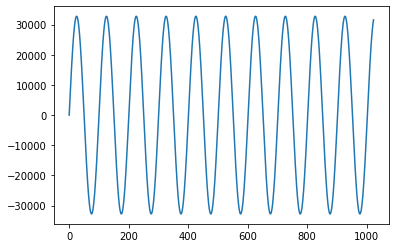

In [5]:
plt.plot(sine)

In [31]:
recordings = np.load('../out/latency.rec.npy')

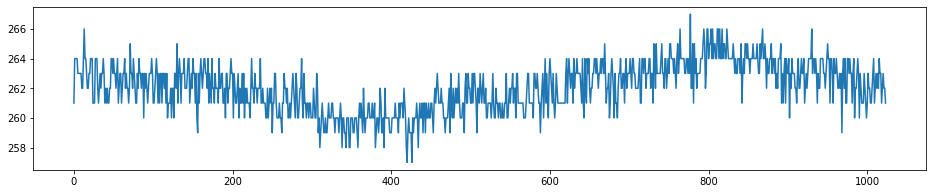

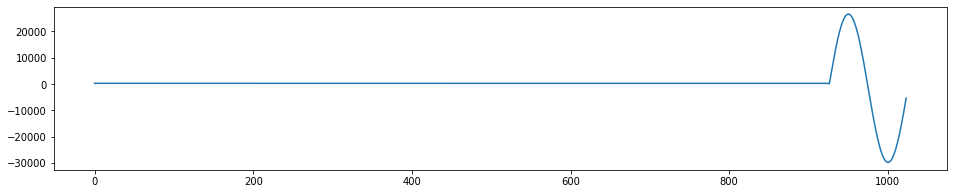

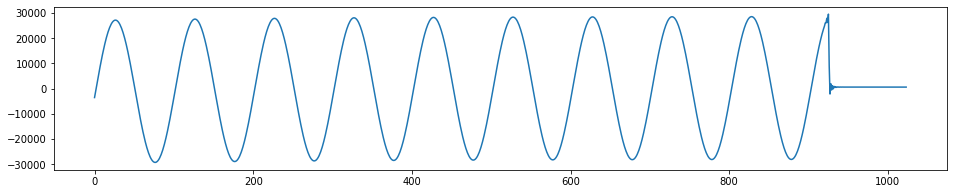

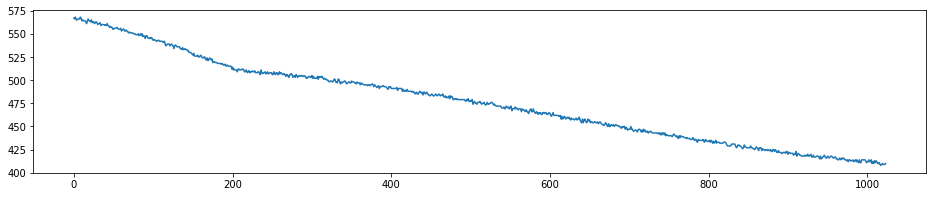

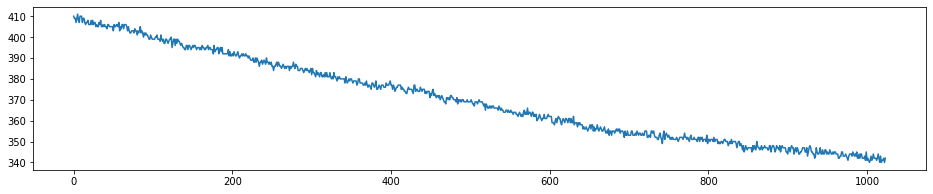

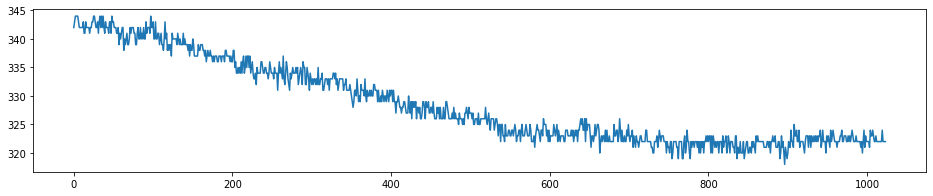

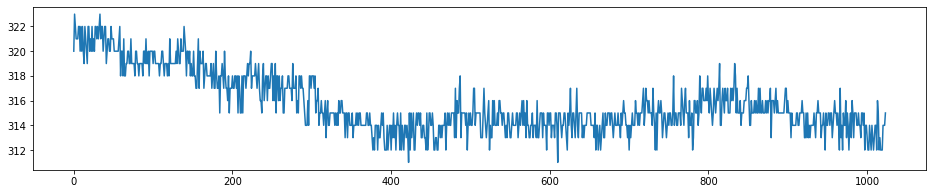

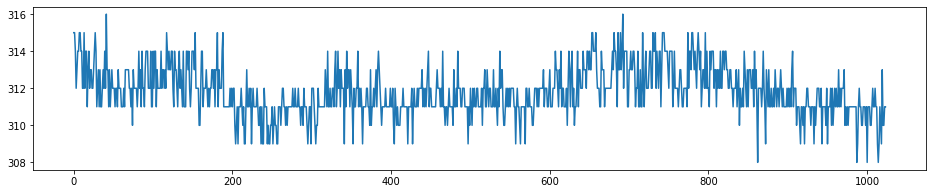

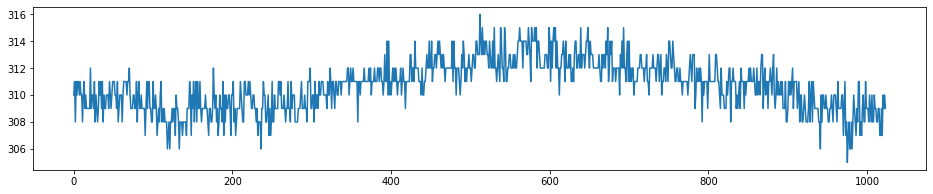

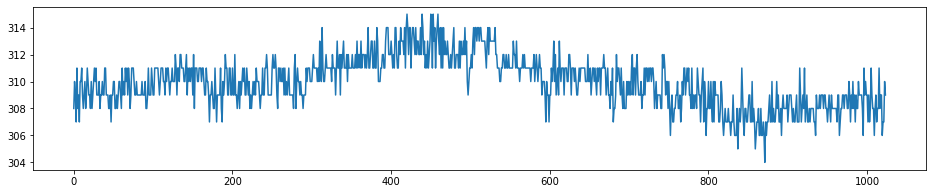

In [32]:
# All chunks plotted separately
plt.rcParams['figure.figsize'] = [16, 3]
for i in range(len(recordings)):
    recording = recordings[i]
    plt.plot(recording)
    plt.show()

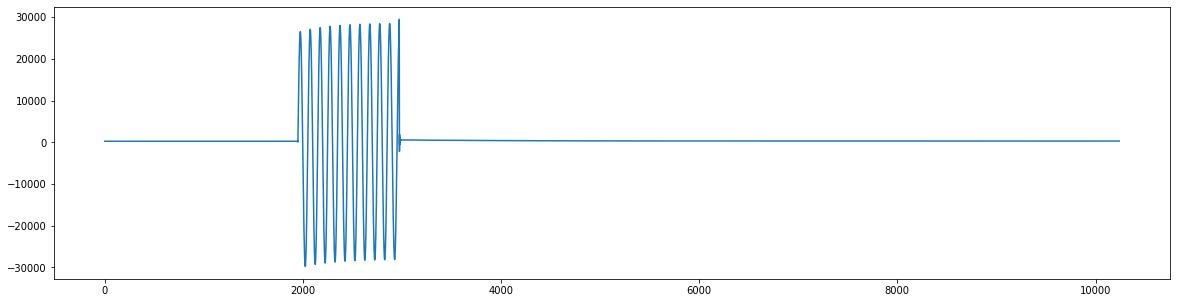

In [33]:
plt.rcParams['figure.figsize'] = [20, 5]
joined = np.concatenate(recordings)
plt.plot(joined)
plt.show()

In [34]:
amplitude = 32767
threshold_amp = amplitude / 2
clip_start = np.argmax(joined>threshold_amp)
clip_start

1961

In [35]:
max_amplitude = max(np.max(joined), -np.min(joined))
max_amplitude

29763

In [36]:
latency_chunks = math.ceil(clip_start / config.chunk_size)
latency_chunks

2

In [38]:
chunk_length_ms = 1000 * config.chunk_size / config.sampling_rate
chunk_length_ms

23.219954648526077

In [39]:
sample_time_s = 1 / config.sampling_rate

In [40]:
latency_ms = clip_start * sample_time_s * 1000
latency_ms

44.467120181405896

In [41]:
# latency based on minimum number of recorded chunks
latency_max_ms = latency_chunks * config.chunk_size * sample_time_s * 1000
latency_max_ms

46.439909297052154

# Full cycle latency

In [94]:
import math

import numpy as np
import matplotlib.pyplot as plt

from looper.runner.config import Config
from looper.runner.plot import plot_series

In [79]:
config = Config()
chunk_size = config.chunk_size

In [80]:
recording = np.load('../out/latency.rec.npy')

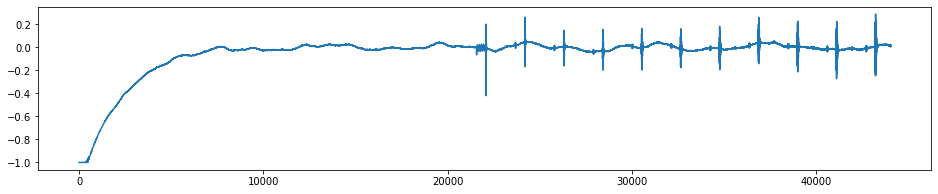

In [81]:
plt.rcParams['figure.figsize'] = [16, 3]
plt.plot(recording)

In [82]:
chunks = len(recording) / config.chunk_size
chunks

43.0

In [83]:
silence_arg = np.argmax((recording<0.1) & (recording > -0.1))
f'Zero threshold reached at sample index {silence_arg} - chunk {silence_arg/chunk_size}'

'Zero threshold reached at sample index 5095 - chunk 4.9755859375'

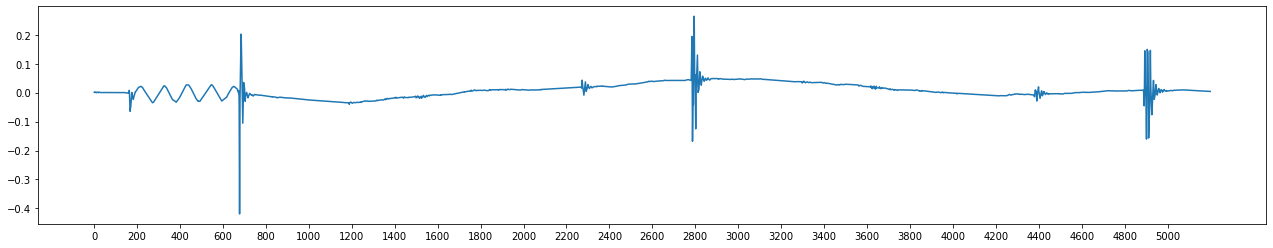

In [104]:
view = recording[21400:26600]
plt.rcParams['figure.figsize'] = [22, 4]
fig = plt.figure()
sub = fig.add_subplot()
sub.plot(view)
sub.set_xticks(np.arange(0, len(view), 200))
plt.show()

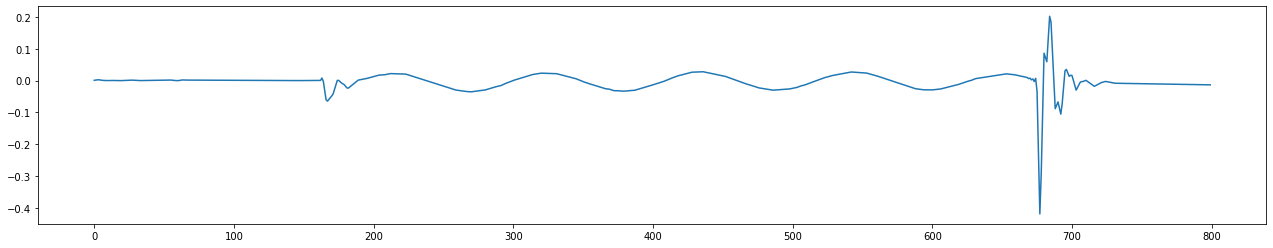

In [106]:
view2 = view[0:800]
plt.rcParams['figure.figsize'] = [22, 4]
plt.plot(view2)

In [113]:
peak_index1 = np.argmax(np.absolute(view2))
peak_index1

677

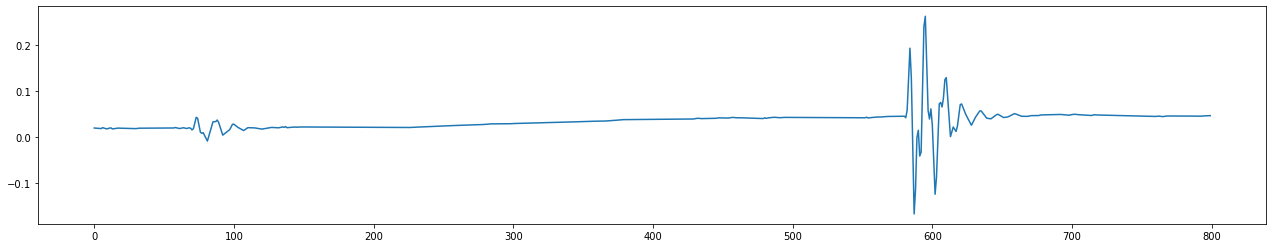

In [114]:
view3 = view[2200:3000]
plt.rcParams['figure.figsize'] = [22, 4]
plt.plot(view3)

In [115]:
peak_index2 = np.argmax(np.absolute(view3)) + 2200
peak_index2

2795

In [118]:
latency_samples = peak_index2 - peak_index1
latency_ms = latency_samples * 1000 / config.sampling_rate
f'Measured latency: {latency_samples} samples, {latency_ms} ms'

'Measured latency: 2118 samples, 44.125 ms'

In [121]:
arming_chunks_num = 20

In [122]:
armed_chunks = recording[arming_chunks_num * chunk_size:]

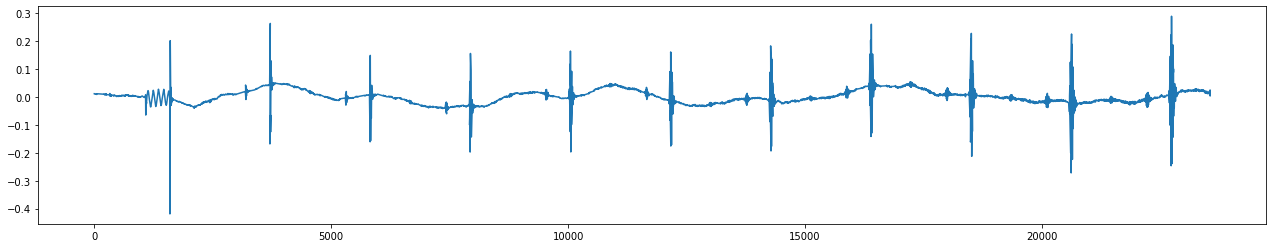

In [132]:
plt.rcParams['figure.figsize'] = [22, 4]
plt.plot(armed_chunks)

In [129]:
peaks_mask = np.absolute(armed_chunks) > 0.1

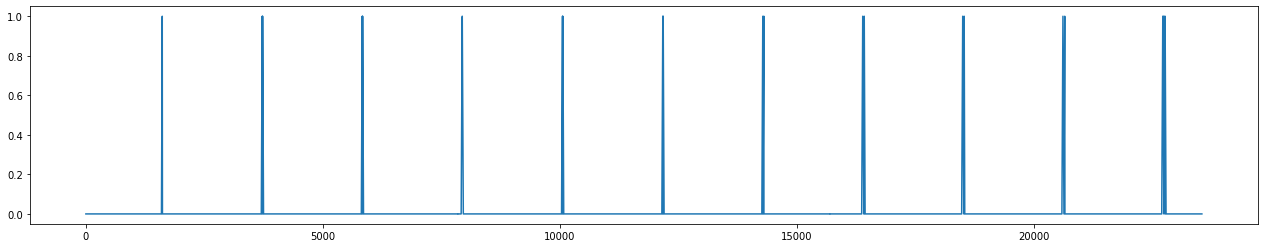

In [136]:
plt.rcParams['figure.figsize'] = [22, 4]
plt.plot(peaks_mask)

In [139]:
peak_indices = []
view = peaks_mask
offset = 0
while True:
    first_peak = np.argmax(view)
    if view[first_peak] == False:
        break
    peak_indices.append(first_peak + offset)
    offset += first_peak+chunk_size
    view = view[first_peak+chunk_size:]
    if view.size == 0:
        break
peak_indices

[1596, 3703, 5814, 7921, 10039, 12156, 14266, 16373, 18483, 20598, 22705]

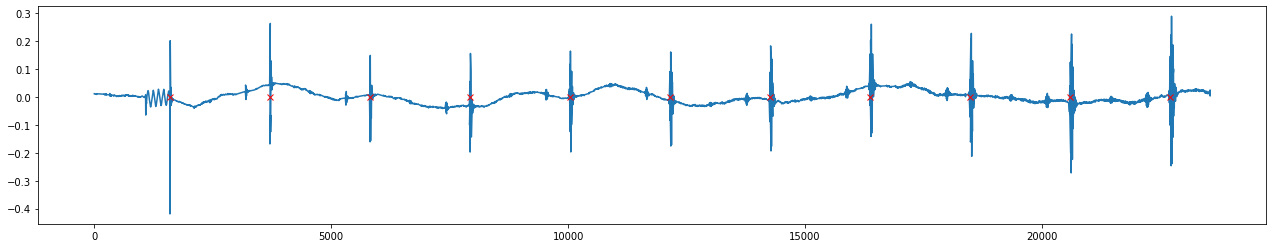

In [148]:
peak_series_x = peak_indices
peak_series_y = [0 for i in peak_indices]

plt.rcParams['figure.figsize'] = [22, 4]
plt.plot(armed_chunks)
plt.plot(peak_series_x, peak_series_y, 'rx', label='line with marker')

In [152]:
peak_indices_diff = []
for i in range(len(peak_indices) - 1):
    peak_indices_diff.append(peak_indices[i+1] - peak_indices[i])
peak_indices_diff

[2107, 2111, 2107, 2118, 2117, 2110, 2107, 2110, 2115, 2107]

In [156]:
latency_median = np.median(peak_indices_diff)
latency_ms = latency_median * 1000 / config.sampling_rate
f'Measured latency: {latency_median} samples, {latency_ms} ms'

'Measured latency: 2110.0 samples, 43.958333333333336 ms'